In [333]:
import numpy as np
import pandas as pd

from fastparquet import ParquetFile,write
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from cm2df import cm2df,precision_recall_fscore_support_metrics2df
from sklearn.metrics import confusion_matrix, classification_report,precision_recall_fscore_support

In [334]:
pf=ParquetFile('subset_feature_4ML_110619.parq')
udf=pf.to_pandas()

In [335]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32880 entries, 11049447 to 9968570
Data columns (total 35 columns):
category                 32880 non-null int64
past                     32880 non-null int32
votes                    32880 non-null int64
is_eventbrite            32880 non-null int32
is_free                  32880 non-null int32
doors                    32880 non-null int32
sold_out                 32880 non-null int32
venue.id                 32880 non-null int64
venue.popularity         32880 non-null float64
venue.zip                32880 non-null int64
ticket_allages           32880 non-null int32
ticket_price_low         32880 non-null float64
ticket_price_max         32880 non-null float64
min_age                  32880 non-null int32
artist.popularity.sum    32880 non-null float64
artist.popularity.avg    32880 non-null float64
artist.popularity.max    32880 non-null float64
dow                      32880 non-null int64
doy                      32880 non-null in

In [4]:
udf['multiday'] = udf['multiday'].astype(int)

In [5]:
usecolsX=['category', 'past', 'is_eventbrite', 'is_free', 'doors',
       'sold_out', 'venue.id', 'venue.popularity', 'venue.zip',
       'ticket_allages', 'ticket_price_low', 'ticket_price_max', 'min_age',
       'artist.popularity.sum', 'artist.popularity.avg',
       'artist.popularity.max', 'dow', 'doy', 'month', 'day', 'hour',
       'venue.tol_num_events', 'duration', 'duration_day', 'multiday']
usecoly1=['votes']
usecoly2=['avg_votes_pday']

In [18]:
udf_X=udf[usecolsX]
udf_y=udf[usecoly1]

In [346]:
# a function to create udf_y based on 3 classes: low, mid, high
def get_class(df,thre1,thre2):
    n=len(df)
    newdf=[]
    cut1=min([thre1,thre2])
    cut2=max([thre1,thre2])
    for item in df:
        if item<cut1: newdf+=[0]
        elif (item<cut2) and (item>=cut1):newdf+=[1]
        else: newdf+=[2]
    return newdf

In [ ]:
y=get_class(udf_y.values,80,300)

In [339]:
# scaling of the features
from sklearn.preprocessing import MinMaxScaler
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(udf_X)
X = scalar.transform(udf_X)
# import algorithms for model comparisons
# tree models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [343]:
# import algorithms for model comparisons
# tree models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# setup the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=12)

## Benchmark Model: Random Forest> 

In [17]:
usecolsX=['category', 'past', 'is_eventbrite', 'is_free', 'doors',
       'sold_out', 'venue.id', 'venue.popularity', 'venue.zip',
       'ticket_allages', 'ticket_price_low', 'ticket_price_max', 'min_age',
       'artist.popularity.sum', 'artist.popularity.avg',
       'artist.popularity.max', 'dow', 'doy', 'month', 'day', 'hour',
       'venue.tol_num_events', 'duration', 'duration_day', 'multiday']
usecoly1=['votes']
usecoly2=['avg_votes_pday']

In [18]:
udf_X=udf[usecolsX+['votes']]
udf_y=udf[usecoly1]
y=get_class(udf_y.values,80,300)

In [19]:
print("number of low votes:",list(y).count(0))
print("number of medium votes:",list(y).count(1))
print("number of high votes:",list(y).count(2))
print("number of features:",len(udf_X.columns))

number of low votes: 31611
number of medium votes: 1059
number of high votes: 210
number of features: 26


In [37]:
# first spare the training data for upsampling
X_train, X_test, y_train, y_test = train_test_split(udf_X, y, test_size=0.3, stratify=y, random_state=12)
print("in the training data:")
print("number of low votes:",list(y_train).count(0))
print("number of medium votes:",list(y_train).count(1))
print("number of high votes:",list(y_train).count(2))
print("in the testing data:")
print("number of low votes:",list(y_test).count(0))
print("number of medium votes:",list(y_test).count(1))
print("number of high votes:",list(y_test).count(2))
# do upsample with replacement
from sklearn.utils import resample
# separate three classes
# add back the 'votes' column, and redo the sampling
mask0=[True if x==0 else False for x in y_train]
mask1=[True if x==1 else False for x in y_train]
mask2=[True if x==2 else False for x in y_train]
class0=X_train.loc[mask0]
class1=X_train.loc[mask1]
class2=X_train.loc[mask2]

in the training data:
number of low votes: 22128
number of medium votes: 741
number of high votes: 147
in the testing data:
number of low votes: 9483
number of medium votes: 318
number of high votes: 63


#### Very Aggresssive upsample of the high votes: upsample high votes to be same as medium (3.5 times more than original)

In [38]:
df_2_upsampled = resample(class2, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(len(class1)*1),    # to upsample to 100% of medium
                                 random_state=12) # reproducible results

In [39]:
# mix all samples
ndf=pd.concat([class0,class1,df_2_upsampled])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [40]:
print("increase sample size on the percentage:",(len(ndf)-len(X_train))/len(X_train)*100,"%")

increase sample size on the percentage: 2.5808133472367047 %


In [41]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [59]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0))
print("number of medium votes:",list(yy).count(1))
print("number of high votes:",list(yy).count(2),",compared with original:",list(y).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 22128
number of medium votes: 6638
number of high votes: 741 ,compared with original: 210
number of features in X: 25


In [43]:
# redo the benchmark model
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [45]:
# spare the X_test with proper versions
X_test=X_test[usecolsX]
X_test=scalar.transform(X_test)


In [12]:
prec_rec=[]
recal_rec=[]
max_f=len(udf_X.columns)

In [13]:
classifier=RandomForestClassifier(n_estimators=80,random_state=12,max_features=int(max_f*0.75),verbose=0)
classifier.fit(X_train,y_train)
pred_y_test=classifier.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)


0.4760812469154372


In [14]:
pred_y_train=classifier.predict(X_train)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(y_train, pred_y_train))
print("other metrics:",classification_report(y_train, pred_y_train))

confusion matrix: [[22127     1     0]
 [    1   740     0]
 [    0     0   147]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00       741
           2       1.00      1.00      1.00       147

    accuracy                           1.00     23016
   macro avg       1.00      1.00      1.00     23016
weighted avg       1.00      1.00      1.00     23016



In [15]:
# print confusion matrix
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9437   41    5]
 [ 209  106    3]
 [  34   15   14]]
other metrics:               precision    recall  f1-score   support

           0       0.97      1.00      0.98      9483
           1       0.65      0.33      0.44       318
           2       0.64      0.22      0.33        63

    accuracy                           0.97      9864
   macro avg       0.76      0.52      0.59      9864
weighted avg       0.96      0.97      0.96      9864



In [46]:
classifier0=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*0.75),verbose=0)
classifier0.fit(X,yy)
pred_y_test=classifier0.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.509652137879281


In [47]:
pred_y_train=classifier0.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(yy, pred_y_train))
print("other metrics:",classification_report(yy, pred_y_train))

confusion matrix: [[22127     1     0]
 [    0   741     0]
 [    0     0   741]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00       741
           2       1.00      1.00      1.00       741

    accuracy                           1.00     23610
   macro avg       1.00      1.00      1.00     23610
weighted avg       1.00      1.00      1.00     23610



In [48]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9434   37   12]
 [ 215   97    6]
 [  31   11   21]]
other metrics:               precision    recall  f1-score   support

           0       0.97      0.99      0.98      9483
           1       0.67      0.31      0.42       318
           2       0.54      0.33      0.41        63

    accuracy                           0.97      9864
   macro avg       0.73      0.54      0.61      9864
weighted avg       0.96      0.97      0.96      9864



#### Add Very Aggresssive upsample of the medium votes: upsample medium votes to be 30% as low votes (~6.3 times more than original)

In [49]:
df_1_upsampled = resample(class1, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(len(class0)*.3),    # to upsample to 30% of low
                                 random_state=12) # reproducible results

In [50]:
# mix all samples
ndf=pd.concat([class0,df_1_upsampled,df_2_upsampled])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [51]:
print("increase sample size on the percentage:",(len(ndf)-len(X_train))/len(X_train)*100,"%")

increase sample size on the percentage: 28.20212026416406 %


In [52]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [60]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0))
print("number of medium votes:",list(yy).count(1),",compared with original:",list(y).count(1))
print("number of high votes:",list(yy).count(2),",compared with original:",list(y).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 22128
number of medium votes: 6638 ,compared with original: 1059
number of high votes: 741 ,compared with original: 210
number of features in X: 25


In [61]:
# redo the benchmark model
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [62]:
classifier1=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*0.75),verbose=0)
classifier1.fit(X,yy)
pred_y_test=classifier1.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.4897649059210892


In [63]:
pred_y_train=classifier1.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(yy, pred_y_train))
print("other metrics:",classification_report(yy, pred_y_train))

confusion matrix: [[22127     1     0]
 [    0  6638     0]
 [    0     0   741]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00      6638
           2       1.00      1.00      1.00       741

    accuracy                           1.00     29507
   macro avg       1.00      1.00      1.00     29507
weighted avg       1.00      1.00      1.00     29507



In [64]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9403   69   11]
 [ 179  131    8]
 [  27   20   16]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.99      0.99      9483
           1       0.60      0.41      0.49       318
           2       0.46      0.25      0.33        63

    accuracy                           0.97      9864
   macro avg       0.68      0.55      0.60      9864
weighted avg       0.96      0.97      0.96      9864



#### Scale down the medium votes upsampling: use a 20% of the low votes(~4 times more than original)

In [65]:
df_1_upsampled = resample(class1, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(len(class0)*.2),    # to upsample to 20% of low
                                 random_state=12) # reproducible results

In [66]:
# mix all samples
ndf=pd.concat([class0,df_1_upsampled,df_2_upsampled])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [67]:
print("increase sample size on the percentage:",(len(ndf)-len(X_train))/len(X_train)*100,"%")

increase sample size on the percentage: 18.587069864442128 %


In [68]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [69]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0))
print("number of medium votes:",list(yy).count(1),",compared with original:",list(y).count(1))
print("number of high votes:",list(yy).count(2),",compared with original:",list(y).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 22128
number of medium votes: 4425 ,compared with original: 1059
number of high votes: 741 ,compared with original: 210
number of features in X: 25


In [70]:
# redo the benchmark model
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [71]:
classifier2=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*.75),verbose=0)
classifier2.fit(X,yy)
pred_y_test=classifier2.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.48872754993361633


In [72]:
pred_y_train=classifier2.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(yy, pred_y_train))
print("other metrics:",classification_report(yy, pred_y_train))

confusion matrix: [[22127     1     0]
 [    0  4425     0]
 [    0     0   741]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00      4425
           2       1.00      1.00      1.00       741

    accuracy                           1.00     27294
   macro avg       1.00      1.00      1.00     27294
weighted avg       1.00      1.00      1.00     27294



In [73]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9401   70   12]
 [ 186  127    5]
 [  26   21   16]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.99      0.98      9483
           1       0.58      0.40      0.47       318
           2       0.48      0.25      0.33        63

    accuracy                           0.97      9864
   macro avg       0.68      0.55      0.60      9864
weighted avg       0.96      0.97      0.96      9864



#### compare to both training and testing case, apparently model is overfitted.

#### Try upsampling for medium and high votes to the same level (30% of the low votes)

In [74]:
# try scale down the ratio of upsampling
df_2_upsampled = resample(class2, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(len(class0)*.3),    # to upsample to 30% of low
                                 random_state=12) # reproducible results
print("upsampled to:",len(df_2_upsampled))

upsampled to: 6638


In [75]:
df_1_upsampled = resample(class1, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(len(class0)*.3),    # to upsample to 30% of low
                                 random_state=12) # reproducible results
print("upsampled to:",len(df_1_upsampled))

upsampled to: 6638


In [76]:
# mix all samples
ndf=pd.concat([class0,df_1_upsampled,df_2_upsampled])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [77]:
print("increase sample size on the percentage:",(len(ndf)-len(X_train))/len(X_train)*100,"%")

increase sample size on the percentage: 53.82342718109141 %


In [78]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [79]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0))
print("number of medium votes:",list(yy).count(1),",compared with original:",list(y).count(1))
print("number of high votes:",list(yy).count(2),",compared with original:",list(y).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 22128
number of medium votes: 6638 ,compared with original: 1059
number of high votes: 6638 ,compared with original: 210
number of features in X: 25


In [80]:
# rescale data input
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [85]:
classifier3=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*.75),verbose=0)
classifier3.fit(X,yy)
pred_y_test=classifier3.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.48810479126763634


In [86]:
pred_y_train=classifier3.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(yy, pred_y_train))
print("other metrics:",classification_report(yy, pred_y_train))

confusion matrix: [[22127     1     0]
 [    0  6638     0]
 [    0     0  6638]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00      6638
           2       1.00      1.00      1.00      6638

    accuracy                           1.00     35404
   macro avg       1.00      1.00      1.00     35404
weighted avg       1.00      1.00      1.00     35404



In [87]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9400   69   14]
 [ 184  129    5]
 [  28   19   16]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.99      0.98      9483
           1       0.59      0.41      0.48       318
           2       0.46      0.25      0.33        63

    accuracy                           0.97      9864
   macro avg       0.68      0.55      0.60      9864
weighted avg       0.96      0.97      0.96      9864



#### Looks like that downsampling the low-votes dramatically would make the distinctions between medium and low vague for the model

### Try do purely 2) down sampling for low votes events

In [88]:
# downsample the low-votes
df_0_downsampled = resample(class0,
                                replace = False, # sample without replacement
                                n_samples = len(class1)*5, # match 5 times the medium class
                                random_state = 12) # reproducible results

In [89]:
# mix all samples
ndf=pd.concat([class2,class1,df_0_downsampled])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [90]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [91]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0),",compared with original:",list(y).count(0))
print("number of medium votes:",list(yy).count(1))
print("number of high votes:",list(yy).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 3705 ,compared with original: 31611
number of medium votes: 741
number of high votes: 147
number of features in X: 25


In [92]:
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [93]:
classifier4=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*.75),verbose=0)
classifier4.fit(X,yy)
pred_y_test=classifier4.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.4523283875696053


In [94]:
pred_y_train=classifier4.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(yy, pred_y_train))
print("other metrics:",classification_report(yy, pred_y_train))

confusion matrix: [[3705    0    0]
 [   0  741    0]
 [   0    0  147]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3705
           1       1.00      1.00      1.00       741
           2       1.00      1.00      1.00       147

    accuracy                           1.00      4593
   macro avg       1.00      1.00      1.00      4593
weighted avg       1.00      1.00      1.00      4593



In [95]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9172  294   17]
 [ 115  198    5]
 [  19   31   13]]
other metrics:               precision    recall  f1-score   support

           0       0.99      0.97      0.98      9483
           1       0.38      0.62      0.47       318
           2       0.37      0.21      0.27        63

    accuracy                           0.95      9864
   macro avg       0.58      0.60      0.57      9864
weighted avg       0.96      0.95      0.96      9864



### Tone down the downsampling of low-votes : (to be 10 times the medium votes)

In [96]:
# downsample the low-votes
df_0_downsampled = resample(class0,
                                replace = False, # sample without replacement
                                n_samples = len(class1)*10, # match 5 times the medium class
                                random_state = 12) # reproducible results

In [97]:
# mix all samples
ndf=pd.concat([class2,class1,df_0_downsampled])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [98]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [99]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0),",compared with original:",list(y).count(0))
print("number of medium votes:",list(yy).count(1))
print("number of high votes:",list(yy).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 7410 ,compared with original: 31611
number of medium votes: 741
number of high votes: 147
number of features in X: 25


In [113]:
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [101]:
classifier5=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*.75),verbose=0)
classifier5.fit(X,yy)
pred_y_test=classifier5.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.4616830726320679


In [102]:
pred_y_train=classifier5.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(yy, pred_y_train))
print("other metrics:",classification_report(yy, pred_y_train))

confusion matrix: [[7410    0    0]
 [   0  741    0]
 [   0    0  147]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7410
           1       1.00      1.00      1.00       741
           2       1.00      1.00      1.00       147

    accuracy                           1.00      8298
   macro avg       1.00      1.00      1.00      8298
weighted avg       1.00      1.00      1.00      8298



In [103]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9331  141   11]
 [ 155  159    4]
 [  25   26   12]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9483
           1       0.49      0.50      0.49       318
           2       0.44      0.19      0.27        63

    accuracy                           0.96      9864
   macro avg       0.64      0.56      0.58      9864
weighted avg       0.96      0.96      0.96      9864



### Try 3) combining the upsample and down sampling : Test1 , low votes downsample 50% to original, medium votes upsample to 30% of low-votes, high votes upsample to be the original medium votes

In [143]:
# downsample the low-votes
df_0_downsampled = resample(class0,
                                replace = False, # sample without replacement
                                n_samples = int(len(class0)*.5), # use only 75% of the original 
                                random_state = 12) # reproducible results

In [144]:
# upsample the mid-votes 
df_1_upsampled = resample(class1,
                                replace = True, # sample with replacement
                                n_samples = int(len(class0)*.30), # match 30% of the low class
                                random_state = 12) # reproducible results

In [145]:
# upsample the high-votes 
df_2_upsampled = resample(class2,
                                replace = True, # sample with replacement
                                n_samples = len(class1), # match the medium class
                                random_state = 12) # reproducible results

In [146]:
# mix all samples
ndf=pd.concat([df_1_upsampled,df_2_upsampled,df_0_downsampled])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [147]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [148]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0),",compared with original:",list(y).count(0))
print("number of medium votes:",list(yy).count(1))
print("number of high votes:",list(yy).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 11064 ,compared with original: 31611
number of medium votes: 6638
number of high votes: 741
number of features in X: 25


In [149]:
print("decrease sample size on the percentage:",(len(ndf)-len(X_train))/len(X_train)*100,"%")

decrease sample size on the percentage: -19.868786930830726 %


In [150]:
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [151]:
classifier6=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*.75),verbose=0)
classifier6.fit(X,yy)
pred_y_test=classifier6.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.49979401037881965


In [152]:
pred_y_train=classifier6.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(yy, pred_y_train))
print("other metrics:",classification_report(yy, pred_y_train))

confusion matrix: [[11063     1     0]
 [    0  6638     0]
 [    0     0   741]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11064
           1       1.00      1.00      1.00      6638
           2       1.00      1.00      1.00       741

    accuracy                           1.00     18443
   macro avg       1.00      1.00      1.00     18443
weighted avg       1.00      1.00      1.00     18443



In [153]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9320  151   12]
 [ 155  154    9]
 [  25   20   18]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9483
           1       0.47      0.48      0.48       318
           2       0.46      0.29      0.35        63

    accuracy                           0.96      9864
   macro avg       0.64      0.58      0.60      9864
weighted avg       0.96      0.96      0.96      9864



In [118]:
# get an average number from 3 groups
print("mean of the cat 0 and 1:",np.mean([list(y_train).count(0),list(y_train).count(1)]))
print("mean of the cat 1 and 2:",np.mean([list(y_train).count(1),list(y_train).count(2)]))
print("mean of means:",np.mean([11434,444]))

mean of the cat 0 and 1: 11434.5
mean of the cat 1 and 2: 444.0
mean of means: 5939.0


### Try 3) combining the upsample and down sampling : Test2 , use low votes downsample 50% to original, medium votes upsample to ~5 times of original, high votes upsample to be 2 times orginal

In [119]:
# downsample the low-votes
df_0_downsampled = resample(class0,
                                replace = False, # sample without replacement
                                n_samples = 11434, # match the medium class
                                random_state = 12) # reproducible results

In [120]:
# upsample the mid-votes 
df_1_upsampled = resample(class1,
                                replace = True, # sample with replacement
                                n_samples = 5939, # match the medium class
                                random_state = 12) # reproducible results

In [121]:
# upsample the high-votes 
df_2_upsampled = resample(class2,
                                replace = True, # sample with replacement
                                n_samples = 444, # match the medium class
                                random_state = 12) # reproducible results

In [122]:
# mix all samples
ndf=pd.concat([df_2_upsampled,df_1_upsampled,df_0_downsampled])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [123]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [124]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0),",compared with original:",list(y).count(0))
print("number of medium votes:",list(yy).count(1),",compared with original:",list(y).count(1))
print("number of high votes:",list(yy).count(2),",compared with original:",list(y).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 11434 ,compared with original: 31611
number of medium votes: 5939 ,compared with original: 1059
number of high votes: 444 ,compared with original: 210
number of features in X: 25


In [125]:
print("decrease sample size on the percentage:",(len(ndf)-len(X_train))/len(X_train)*100,"%")

decrease sample size on the percentage: -22.588633993743482 %


In [126]:
# scale classifier dataset
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [127]:
classifier7=RandomForestClassifier(n_estimators=20,random_state=12,verbose=0)
classifier7.fit(X,yy)
pred_y_test=classifier7.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.46608448780117406


In [128]:
pred_y_train=classifier7.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(yy, pred_y_train))
print("other metrics:",classification_report(yy, pred_y_train))

confusion matrix: [[11433     1     0]
 [    0  5939     0]
 [    0     1   443]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11434
           1       1.00      1.00      1.00      5939
           2       1.00      1.00      1.00       444

    accuracy                           1.00     17817
   macro avg       1.00      1.00      1.00     17817
weighted avg       1.00      1.00      1.00     17817



In [129]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9357  120    6]
 [ 158  157    3]
 [  30   22   11]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.99      0.98      9483
           1       0.53      0.49      0.51       318
           2       0.55      0.17      0.27        63

    accuracy                           0.97      9864
   macro avg       0.69      0.55      0.59      9864
weighted avg       0.96      0.97      0.96      9864



In [173]:
prec_rec

[array([0.97489669, 0.65432099, 0.63636364]),
 array([0.97458678, 0.66896552, 0.53846154]),
 array([0.97856177, 0.59545455, 0.45714286]),
 array([0.97794653, 0.58256881, 0.48484848]),
 array([0.97794424, 0.59447005, 0.45714286]),
 array([0.98560069, 0.37858509, 0.37142857]),
 array([0.98107455, 0.48773006, 0.44444444]),
 array([0.98115591, 0.4689441 , 0.39534884]),
 array([0.98030382, 0.52508361, 0.55      ])]

In [178]:
high_prec=[x[2] for x in prec_rec]
high_recal=[x[2] for x in recal_rec]

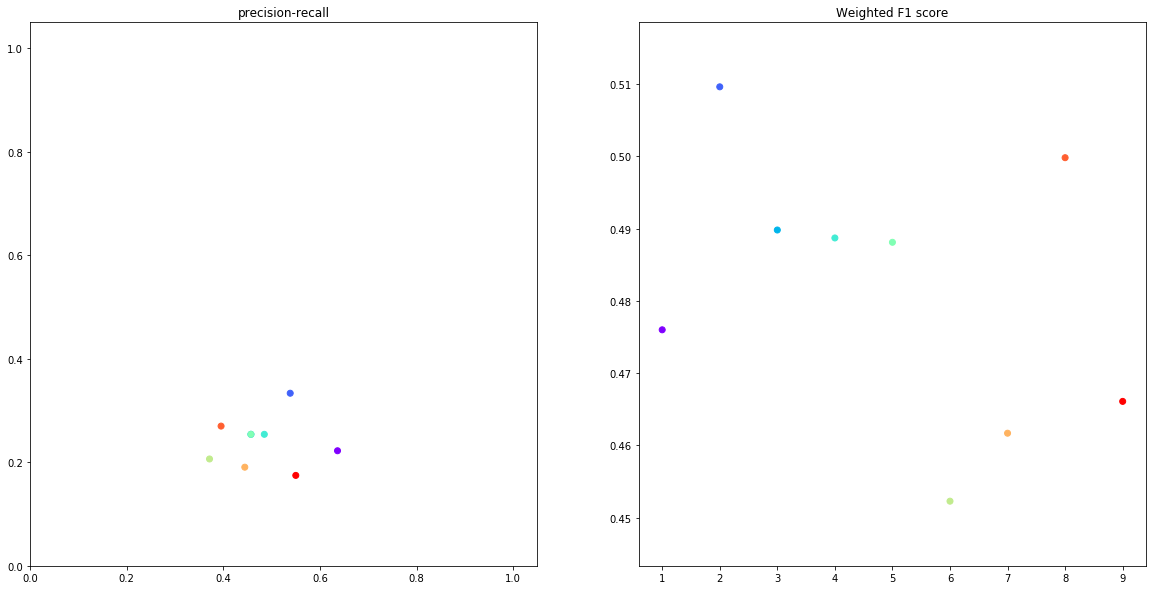

In [183]:
# plot the final results

# set up matplot figure
fig =plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('precision-recall')
ax1.set_xlim([0,1.05])
ax1.set_ylim([0,1.05])
ax2.title.set_text('Weighted F1 score')
# preset color scale
NUM_COLORS = 9
colors = cm.rainbow(np.linspace(0, 1, NUM_COLORS))
ct=0# counter for colors

ax1.scatter(high_prec,high_recal,color=colors)
ax2.scatter([1,2,3,4,5,6,7,8,9],[0.476,0.5096,0.4898,0.4887,0.4881,0.4523,0.4617,0.4998,0.4661],color=colors)

### Try 4) SMOTE upsample the high-votes: extreme, upsample the high votes to same value of medium votes with SMOTE

In [187]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [212]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train.iloc[:,0:25], y_train)

In [213]:
print(sorted(Counter(y_resampled).items()))

[(0, 22128), (1, 22128), (2, 22128)]


In [214]:
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(X_resampled)
X = scalar.transform(X_resampled)

In [215]:
classifier8=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*.75),verbose=0)
classifier8.fit(X,y_resampled)
pred_y_test=classifier8.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.48389815194237656


In [217]:
pred_y_train=classifier8.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(y_resampled, pred_y_train))
print("other metrics:",classification_report(y_resampled, pred_y_train))

confusion matrix: [[22127     1     0]
 [    0 22128     0]
 [    0     0 22128]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00     22128
           2       1.00      1.00      1.00     22128

    accuracy                           1.00     66384
   macro avg       1.00      1.00      1.00     66384
weighted avg       1.00      1.00      1.00     66384



In [218]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9341  124   18]
 [ 161  148    9]
 [  24   22   17]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.99      0.98      9483
           1       0.50      0.47      0.48       318
           2       0.39      0.27      0.32        63

    accuracy                           0.96      9864
   macro avg       0.62      0.57      0.59      9864
weighted avg       0.96      0.96      0.96      9864



### Same upsampling from random sampling

In [219]:
# upsample the mid-votes 
df_1_upsampled = resample(class1,
                                replace = True, # sample with replacement
                                n_samples = int(len(class0)), # match 30% of the low class
                                random_state = 12) # reproducible results

In [220]:
# upsample the high-votes 
df_2_upsampled = resample(class2,
                                replace = True, # sample with replacement
                                n_samples = len(class0), # match the medium class
                                random_state = 12) # reproducible results

In [221]:
# mix all samples
ndf=pd.concat([df_2_upsampled,df_1_upsampled,class0])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [222]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [223]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0))
print("number of medium votes:",list(yy).count(1),",compared with original:",list(y).count(1))
print("number of high votes:",list(yy).count(2),",compared with original:",list(y).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 22128 ,compared with original: 31611
number of medium votes: 22128 ,compared with original: 1059
number of high votes: 22128 ,compared with original: 210
number of features in X: 25


In [225]:
print("increase sample size on the percentage:",(len(ndf)-len(X_train))/len(X_train)*100,"%")

increase sample size on the percentage: 188.42544316996873 %


In [226]:
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [227]:
classifier8=RandomForestClassifier(n_estimators=20,random_state=12,verbose=0)
classifier8.fit(X,yy)
pred_y_test=classifier8.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.4828428005877874


In [228]:
pred_y_train=classifier8.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(yy, pred_y_train))
print("other metrics:",classification_report(yy, pred_y_train))

confusion matrix: [[22126     2     0]
 [    0 22128     0]
 [    0     0 22128]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00     22128
           2       1.00      1.00      1.00     22128

    accuracy                           1.00     66384
   macro avg       1.00      1.00      1.00     66384
weighted avg       1.00      1.00      1.00     66384



In [229]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9427   49    7]
 [ 192  118    8]
 [  33   15   15]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.99      0.99      9483
           1       0.65      0.37      0.47       318
           2       0.50      0.24      0.32        63

    accuracy                           0.97      9864
   macro avg       0.71      0.53      0.59      9864
weighted avg       0.96      0.97      0.96      9864



### SMOTE upsampling is slightly better

#### Try ADASYN upsampling

In [230]:
from imblearn.over_sampling import ADASYN

In [231]:
X_resampled, y_resampled = ADASYN().fit_resample(X_train.iloc[:,0:25], y_train)

In [232]:
print(sorted(Counter(y_resampled).items()))

[(0, 22128), (1, 22207), (2, 22155)]


In [233]:
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(X_resampled)
X = scalar.transform(X_resampled)

In [234]:
classifier9=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*.75),verbose=0)
classifier9.fit(X,y_resampled)
pred_y_test=classifier9.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.46969548577127157


In [235]:
pred_y_train=classifier9.predict(X)
# print confusion matrix-- training
print("confusion matrix:",confusion_matrix(y_resampled, pred_y_train))
print("other metrics:",classification_report(y_resampled, pred_y_train))

confusion matrix: [[22127     1     0]
 [    0 22207     0]
 [    0     0 22155]]
other metrics:               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22128
           1       1.00      1.00      1.00     22207
           2       1.00      1.00      1.00     22155

    accuracy                           1.00     66490
   macro avg       1.00      1.00      1.00     66490
weighted avg       1.00      1.00      1.00     66490



In [236]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9330  133   20]
 [ 157  150   11]
 [  25   22   16]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9483
           1       0.49      0.47      0.48       318
           2       0.34      0.25      0.29        63

    accuracy                           0.96      9864
   macro avg       0.60      0.57      0.58      9864
weighted avg       0.96      0.96      0.96      9864



### Test combining downsampling low-votes and then SMOTE the medium and high votes

In [253]:
# downsample the low-votes
df_0_downsampled = resample(class0,
                                replace = False, # sample without replacement
                                n_samples = int(len(class0)*.5), # match the medium class
                                random_state = 12) # reproducible results
print(len(df_0_downsampled),len(class0))

11064 22128


In [238]:
# mix all samples
ndf=pd.concat([class1,class2,df_0_downsampled])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [239]:
## make the target classes, and then drop the votes from X data
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [244]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0),",compared with original:",list(y_train).count(0))
print("number of medium votes:",list(yy).count(1))
print("number of high votes:",list(yy).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 11064 ,compared with original: 22128
number of medium votes: 741
number of high votes: 147
number of features in X: 25


In [241]:
# rescale the features:
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [242]:
X_resampled, y_resampled = SMOTE().fit_resample(X, yy)

In [249]:
# rescale the features:
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

in the upsampled/downsample training data:
number of low votes: 11064 ,compared with original: 22128
number of medium votes: 11064 ,compared with original: 741
number of high votes: 11064 ,compared with original: 147
number of features in X: 25


In [250]:
classifier9=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*.75),verbose=0)
classifier9.fit(X_resampled,y_resampled)
pred_y_test=classifier9.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.45013124323262693


In [251]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9043  375   65]
 [  99  206   13]
 [  12   28   23]]
other metrics:               precision    recall  f1-score   support

           0       0.99      0.95      0.97      9483
           1       0.34      0.65      0.44       318
           2       0.23      0.37      0.28        63

    accuracy                           0.94      9864
   macro avg       0.52      0.66      0.57      9864
weighted avg       0.96      0.94      0.95      9864



### Test combining downsampling low-votes less aggressively (75%)and then SMOTE the medium and high votes: Less aggressive low-votes downsampling and then SMOTE medium and high to 50% of the number of low-votes

In [258]:
# downsample the low-votes
df_0_downsampled = resample(class0,
                            replace = False, # sample without replacement
                            n_samples = int(len(class0)*.75), # downsample to 75% original
                            random_state = 12) # reproducible results
print(len(df_0_downsampled))

16596


In [270]:
# subsample 75% of the low-votes
n=int(len(df_0_downsampled)*.5)
df_0_downsub = df_0_downsampled[:n]
df_0_rest = df_0_downsampled[n+1:]

In [267]:
# combine the 75% of the low votes and the mid/high
ndf=pd.concat([class1,class2,df_0_downsub])
# re-shuffle the order
ndf=ndf.sample(frac=1)

In [271]:
# get the classes for the part that going into SMOTE
yyy= get_class(ndf['votes'].values,80,300)

In [272]:
# SMOTE the mid and low
X_resampled, y_resampled = SMOTE().fit_resample(ndf,yyy)

In [294]:
print(sorted(Counter(y_resampled).items()))

[(0, 8298), (1, 8298), (2, 8298)]


In [287]:
df_0_tol = pd.DataFrame(X_resampled, columns=usecolsX+['votes'])
# add back the dataframes and reshuffle
ndf=pd.concat([df_0_tol,df_0_rest])
ndf=ndf.sample(frac=1)

In [289]:
yy=get_class(ndf['votes'].values,80,300)
ndf=ndf[usecolsX]

In [290]:
# rescale the features:
scalar = MinMaxScaler()
scalar.fit(ndf)
X = scalar.transform(ndf)

In [292]:
print("in the upsampled training data:")
print("number of low votes:",list(yy).count(0),",compared with original:",list(y_train).count(0))
print("number of medium votes:",list(yy).count(1),list(y_train).count(1))
print("number of high votes:",list(yy).count(2),list(y_train).count(2))
print("number of features in X:",len(ndf.columns))

in the upsampled training data:
number of low votes: 16595 ,compared with original: 22128
number of medium votes: 8298 741
number of high votes: 8298 147
number of features in X: 25


In [291]:
classifier10=RandomForestClassifier(n_estimators=90,random_state=12,max_features=int(max_f*.75),verbose=0)
classifier10.fit(X,yy)
pred_y_test=classifier10.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.47403047137725024


In [293]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9333  129   21]
 [ 156  153    9]
 [  23   24   16]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.98      0.98      9483
           1       0.50      0.48      0.49       318
           2       0.35      0.25      0.29        63

    accuracy                           0.96      9864
   macro avg       0.61      0.57      0.59      9864
weighted avg       0.96      0.96      0.96      9864



In [295]:
# NN models
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# Try the Neural network model with up/down sample dataset
# formulate y data (specifically required by NN model)
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(yy)
encoded_Y = encoder.transform(yy)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [323]:
nfeature=X.shape[1]
Nmodel=Sequential()
Nmodel.add(Dense(nfeature+5,input_dim=nfeature, activation='relu'))
#Nmodel.add(Dense(nfeature+5, activation='relu'))
#Nmodel.add(Dense(nfeature, activation='relu'))
Nmodel.add(Dense(nfeature-5, activation='relu'))
Nmodel.add(Dense(3, activation='softmax'))

In [324]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [325]:
Nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m,precision_m, recall_m])

In [326]:
Nmodel.fit(X, dummy_y, epochs=50) 

Epoch 1/50
33191/33191 [==============================] - ETA: 2s - loss: 1.1798 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+0 - ETA: 0s - loss: 0.9650 - f1_m: 0.3439 - precision_m: 0.5979 - recall_m: 0.2595            - ETA: 0s - loss: 0.8918 - f1_m: 0.4676 - precision_m: 0.6704 - recall_m: 0.378 - ETA: 0s - loss: 0.8445 - f1_m: 0.5241 - precision_m: 0.7013 - recall_m: 0.435 - ETA: 0s - loss: 0.8114 - f1_m: 0.5611 - precision_m: 0.7176 - recall_m: 0.476 - ETA: 0s - loss: 0.7874 - f1_m: 0.5856 - precision_m: 0.7277 - recall_m: 0.505 - ETA: 0s - loss: 0.7697 - f1_m: 0.6026 - precision_m: 0.7347 - recall_m: 0.524 - 0s 10us/step - loss: 0.7594 - f1_m: 0.6114 - precision_m: 0.7389 - recall_m: 0.5349
Epoch 2/50
33191/33191 [==============================] - ETA: 2s - loss: 0.8374 - f1_m: 0.6296 - precision_m: 0.7727 - recall_m: 0.531 - ETA: 0s - loss: 0.6292 - f1_m: 0.7191 - precision_m: 0.7876 - recall_m: 0.663 - ETA: 0s - loss: 0.6201 - f1_m: 0.7233 - precision_m: 0.7

In [330]:
pred_y_test = Nmodel.predict(X_test)
pred_y_testNN = np.argmax(pred_y_test,axis=1) 

In [331]:
a=precision_recall_fscore_support(y_test, list(pred_y_testNN))
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)

0.3380640013831903


In [332]:
# print confusion matrix-- testing
print("confusion matrix:",confusion_matrix(y_test, pred_y_testNN))
print("other metrics:",classification_report(y_test, pred_y_testNN))

confusion matrix: [[8759  522  202]
 [ 128  155   35]
 [  24   14   25]]
other metrics:               precision    recall  f1-score   support

           0       0.98      0.92      0.95      9483
           1       0.22      0.49      0.31       318
           2       0.10      0.40      0.15        63

    accuracy                           0.91      9864
   macro avg       0.43      0.60      0.47      9864
weighted avg       0.95      0.91      0.93      9864

